## MedMnist Dataset

Followed example notebook from MedMNIST here:
https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb
https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html

In [1]:
from collections import defaultdict
import time
import os

import numpy as np

from tqdm import tqdm

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import autograd, optim
import torch.backends.cudnn as cudnn
import torch.nn as nn

import torchvision.utils as vutils

cudnn.benchmark = True
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.0.2 @ https://github.com/MedMNIST/MedMNIST/


Check what are in the INFO:

In [7]:
print(type(INFO))

<class 'dict'>


In [8]:
print(INFO.keys(), len(INFO.keys()))
# Looks like 18 datasets available, 6 3D

dict_keys(['pathmnist', 'chestmnist', 'dermamnist', 'octmnist', 'pneumoniamnist', 'retinamnist', 'breastmnist', 'bloodmnist', 'tissuemnist', 'organamnist', 'organcmnist', 'organsmnist', 'organmnist3d', 'nodulemnist3d', 'adrenalmnist3d', 'fracturemnist3d', 'vesselmnist3d', 'synapsemnist3d']) 18


In [9]:
INFO['pathmnist']
# Print out one of the dataset to observe the structure

{'python_class': 'PathMNIST',
 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.',
 'url': 'https://zenodo.org/record/5208230/files/pathmnist.npz?download=1',
 'MD5': 'a8b06965200029087d5bd730944a56c1',
 'task': 'multi-class',
 'label': {'0': 'adipose',
  '1': 'background',
  '2': 'debris',
  '3': 'lymphocytes',
  '4': 'mucus',
  '5': 'smooth muscle',
  '6': 'normal colon mucosa',
  '7': 'cancer-associated stroma',
  '8': '

In [9]:
data_flag = 'pathmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [11]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True)

train_loader_at_eval = DataLoader(dataset=train_dataset, 
                                       batch_size=2*BATCH_SIZE, 
                                       shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                              batch_size=2*BATCH_SIZE, 
                              shuffle=False)

Using downloaded and verified file: /Users/chi-hsuanchang/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/chi-hsuanchang/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/chi-hsuanchang/.medmnist/pathmnist.npz


/Users/chi-hsuanchang/opt/miniconda3/envs/local_gan/lib/python3.8/site-packages/medmnist/utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


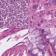

In [31]:
# visualization
train_dataset.montage(length=2)

In [34]:
print(inspect.getsource(medmnist.utils.montage2d))

def montage2d(imgs, n_channels, sel):

    sel_img = imgs[sel]
    montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))
    montage_img = Image.fromarray(montage_arr)

    return montage_img



In [29]:
import inspect
print(inspect.getsource(medmnist.dataset.MedMNIST2D))

class MedMNIST2D(MedMNIST):

    def __getitem__(self, index):
        '''
        return: (without transform/target_transofrm)
            img: PIL.Image
            target: np.array of `L` (L=1 for single-label)
        '''
        img, target = self.imgs[index], self.labels[index].astype(int)
        img = Image.fromarray(img)

        if self.as_rgb:
            img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def save(self, folder, postfix="png", write_csv=True):

        from medmnist.utils import save2d

        save2d(imgs=self.imgs,
               labels=self.labels,
               img_folder=os.path.join(folder, self.flag),
               split=self.split,
               postfix=postfix,
               csv_path=os.path.join(folder, f"{self.flag}.csv") if write_csv else None)

    def montage(se

In [39]:
print(inspect.getsource(nn.Conv2d))

class Conv2d(_ConvNd):
    __doc__ = r"""Applies a 2D convolution over an input signal composed of several input
    planes.

    In the simplest case, the output value of the layer with input size
    :math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
    can be precisely described as:

    .. math::
        \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
        \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


    where :math:`\star` is the valid 2D `cross-correlation`_ operator,
    :math:`N` is a batch size, :math:`C` denotes a number of channels,
    :math:`H` is a height of input planes in pixels, and :math:`W` is
    width in pixels.
    """ + r"""

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    * :attr:`stride` controls the stride for the cross-correlation, a single
      number or a tuple.

    * :attr:`padding` controls the amount of pa

In [36]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [37]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████| 704/704 [02:39<00:00,  4.41it/s]


In [40]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.976  acc:0.755
test  auc: 0.958  acc:0.653


In [42]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/medmnist_experiment_1')

In [45]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

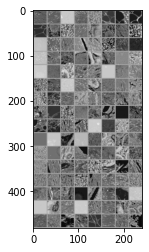

In [46]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = vutils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('medmnist_mnist_images', img_grid)

In [49]:
writer.add_graph(model, images)
writer.close()